In [3]:
import random
import tqdm
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, StratifiedKFold

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def encode_seqCDR(seqCDR):
    encoding_list = []
    for i in range(len(seqCDR)):
        if seqCDR[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        else:
            encoding_list.append(af.loc[seqCDR[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [ ]:
# for dataset 230220.csv
class TCRDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        df_ng = df.copy()
        df_ng = df_ng[df_ng["HLA"] != "-"]
        df_ng["Class"] = "negative"
        df_ng["AseqCDR_3"] = df_ng["AseqCDR_3"].apply(
            lambda x: random.choice(list(set(df["AseqCDR_3"]) - set(x))))
        df_ng["BseqCDR_3"] = df_ng["BseqCDR_3"].apply(
            lambda x: random.choice(list(set(df["BseqCDR_3"]) - set(x))))
        df_pos = df[df["Class"] == "positive"]
        df = pd.concat([df_pos, df_ng], axis=0)
        df = df["HLA", "Neo", "AseqCDR_3", "BseqCDR_3", "Class"]
        seq_list = ["AseqCDR_3", "BseqCDR_3"]
        len_map = df[seq_list].applymap(len).max()
        X_feature = np.zeros((len(df), 0))
        for column in seq_list:
            df[column] = df[column].str.ljust(len_map[column], "*")
            encode_seq_result = list()
            for i in df[column]:
                encode_seq_result.append(encode_seqCDR(i))
            col_name = column + "_encode"
            df[col_name] = encode_seq_result
            col_feature = np.zeros((0, len_map[column]*5))
            for i in range(len(df)):
                col_feature = np.vstack((col_feature, df.loc[i, col_name].reshape(1, -1)))
            X_feature = np.hstack((X_feature, col_feature))

In [3]:
# for more complicated dataset which the HLA has more than 14 types
class HLAAutoEncoder_twoLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HLAAutoEncoder_twoLayer, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim*4),
            nn.ReLU(True),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.ReLU(True),
            nn.Linear(hidden_dim*2, hidden_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(True),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.ReLU(True),
            nn.Linear(hidden_dim*4, input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [ ]:
model = HLAAutoEncoder_twoLayer(input_dim=5*len(df["aaSeqHLA"].unique().max()), hidden_dim=10)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)

In [ ]:
epochs = 20
output = []
losses = []
for epoch in range(epochs):
    for idx, (data) in enumerate(train_loader):
        data = Variable(data).float()
        optimizer.zero_grad()

# 230221 dataset analysis

In [4]:
df = pd.read_excel("/DATA/User/wuxinchao/project/data/seqData/pMHC-TCR_20230221_Info.xlsx")
# select the HLA:HLA-A*02:01, HLA-A*11:01
df = df[(df["HLA"] == "HLA-A*02:01") | (df["HLA"] == "HLA-A*11:01")]
# set the index of cellname and chain
df = df.set_index(['cellname', "chain"])
# extract the NeoAA, HLA, and aaSeqCDR columns
df = df[["NeoAA", "HLA", "aaSeqCDR1", "aaSeqCDR2", "aaSeqCDR3", "Class"]]
df["aaSeqCDR"] = df[df.columns[2:-1]].apply(
    # lambda x: x[0] + 'X' * (7 - len(x[0])) + x[1] + x[2],
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)

idx = pd.IndexSlice

df_a = df.loc[idx[:,"TRA"],]
df_a["AseqCDR"] = df_a["aaSeqCDR"]
df_a.drop(columns=["aaSeqCDR","aaSeqCDR1","aaSeqCDR2","aaSeqCDR3"], inplace=True)
# drop the chain index
df_a.index = df_a.index.droplevel(1)
# print(df_a)
df_b = df.loc[idx[:,"TRB"],]
df_b["BseqCDR"] = df_b["aaSeqCDR"]
df_b.drop(columns=["aaSeqCDR","aaSeqCDR1","aaSeqCDR2","aaSeqCDR3"], inplace=True)
# drop the chain index
df_b.index = df_b.index.droplevel(1)
# print(df_b)

# merge the TRA and TRB dataframes by cellname, HLAs, and NeoAA
df_ab = pd.merge(df_a, df_b, on=["cellname", "HLA", "NeoAA", "Class"])

df = df_ab
# select the NeoAA first 3 aa and last 3 aa as new column
df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])
# df["NeoAA"].value_counts()

/tmp/ipykernel_451163/2328245337.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a["AseqCDR"] = df_a["aaSeqCDR"]
/tmp/ipykernel_451163/2328245337.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.drop(columns=["aaSeqCDR","aaSeqCDR1","aaSeqCDR2","aaSeqCDR3"], inplace=True)
/tmp/ipykernel_451163/2328245337.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

SSCMGGMNQR     494
VVGAVGVGK      373
VVVGAGDVGK     143
ATAPSLSGK      118
VVVGADGVGK      99
SVCAGILSY       79
VLLSHLSYL       77
ATATAPSLSGK     76
TTAPPLSGK       64
VVGAGDVGK       42
SLMEQIPHL       18
LVTDDLLTL       14
SLLMWITQC        9
ELAGIGILTV       8
FLSEQLSIKL       6
GVLEVSHSI        6
AAGIGILTV        2
GILGFVFTL        2
NLVPMVATV        2
GTSGSPIVNR       1
LLFGYAVYV        1
ELAGIGALTV       1
ELAAIGILTV       1
LLFGYPVAV        1
YLEPGPVTV        1
SLYNTIATL        1
EAAGIGILTV       1
SLFNTIAVL        1
GILEFVFTL        1
SLLMWITQV        1
ALWGFFPVL        1
LLFGYPVYV        1
SLYNTVATL        1
Name: NeoAA, dtype: int64

In [5]:
# Determine whether to use Neo column, and the decision is not to use
# Instead, we use encoding of NeoAA
df["Neo"] = df["NeoAA"].str.slice(0,3) + "_" + df["NeoAA"].str.slice(-4,-1)
df.drop(columns=["NeoAA"], inplace=True)
df["Neo"].value_counts()

SSC_MNQ    494
VVG_GVG    373
ATA_LSG    194
VVV_DVG    143
VVV_GVG     99
SVC_ILS     79
VLL_LSY     77
TTA_LSG     64
VVG_DVG     42
SLM_IPH     18
LVT_LLT     14
SLL_ITQ     10
ELA_ILT      9
GVL_SHS      6
FLS_SIK      6
GIL_VFT      3
AAG_ILT      2
NLV_VAT      2
YLE_PVT      1
LLF_PVY      1
SLF_IAV      1
SLY_VAT      1
SLY_IAT      1
GTS_IVN      1
LLF_PVA      1
ELA_ALT      1
LLF_AVY      1
ALW_FPV      1
EAA_ILT      1
Name: Neo, dtype: int64

In [6]:
df["HLA"].value_counts()

HLA-A*11:01    1489
HLA-A*02:01     157
Name: HLA, dtype: int64

In [11]:
df["Class"].value_counts()

positive    1109
negative     537
Name: Class, dtype: int64

In [10]:
# This is the final output dataframe that we need to use
# df = df.drop(columns=["Neo"])
df.to_csv("~/data/project/data/seqData/230221.csv")

In [12]:
class TCRDataset(Dataset):
    def __init__(self, file_path):
        # super(TCRDataset, self).__init__()
        df = pd.read_csv(file_path, index_col=0)
        # get the CDR3 region
        for chain in ["AseqCDR", "BseqCDR"]:
            # df[chain+"_1"] = df[chain].str.split("_").str[0]
            # df[chain+"_2"] = df[chain].str.split("_").str[1]
            df[chain+"_3"] = df[chain].str.split("_").str[2]
            df.drop(columns=[chain], inplace=True)
        df_ps = df[df["Class"] == "positive"]
        df_ng_ex = df[df["Class"] == "negative"]
        df_ng_em = df.copy()
        df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
        df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
        df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
        df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
        df_ng.index = range(len(df_ng))
        df = pd.concat([df_ps, df_ng], axis=0)
        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))
        # encode the CDR3 region
        len_map = {
            "AseqCDR_3": df["AseqCDR_3"].apply(lambda x: len(x)).max(),
            "BseqCDR_3": df["BseqCDR_3"].apply(lambda x: len(x)).max(),
        }
        for chain in ["AseqCDR_3", "BseqCDR_3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

        # encode HLA type through one-hot encoding
        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()

        X_features = torch.zeros((len(df),0))
        for seq in ["Neo_first3", "Neo_last3", "AseqCDR_3", "BseqCDR_3"]:
            # X_features = df[seq]
            # print(df[seq].values.shape)
            # convert the df[seq] into torch tensor
            X_features = torch.cat((X_features, 
            torch.from_numpy(np.vstack(df[seq].values))), dim=1)
        
        X = torch.cat((torch.from_numpy(X_HLA_encoded), X_features), dim=1)
        # encode the class label
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        self.X = X
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [88]:
# only for test
file_path = "~/data/project/data/seqData/230221.csv"
df = pd.read_csv(file_path, index_col=0)
# get the CDR3 region
for chain in ["AseqCDR", "BseqCDR"]:
    # df[chain+"_1"] = df[chain].str.split("_").str[0]
    # df[chain+"_2"] = df[chain].str.split("_").str[1]
    df[chain+"_3"] = df[chain].str.split("_").str[2]
    df.drop(columns=[chain], inplace=True)
# delete the index
df_ps = df[df["Class"] == "positive"]
df_ng_ex = df[df["Class"] == "negative"]
df_ng_em = df.copy()
df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
df_ng.index = range(len(df_ng))
df = pd.concat([df_ps, df_ng], axis=0)
# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))
# encode the CDR3 region
len_map = {
    "AseqCDR_3": df["AseqCDR_3"].apply(lambda x: len(x)).max(),
    "BseqCDR_3": df["BseqCDR_3"].apply(lambda x: len(x)).max(),
}
for chain in ["AseqCDR_3", "BseqCDR_3"]:
    length = len_map[chain]
    # print(length)
    df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
    df[chain] = df[chain].apply(lambda x: encode_seqCDR(x).reshape(1, -1))

# encode HLA type through one-hot encoding
X_HLA = df["HLA"].values.reshape(-1, 1)
HLAencoder = OneHotEncoder()
X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()

X_features = torch.zeros((len(df),0))
for seq in ["Neo_first3", "Neo_last3", "AseqCDR_3", "BseqCDR_3"]:
    # X_features = df[seq]
    # print(df[seq].values.shape)
    # convert the df[seq] into torch tensor
    X_features = torch.cat((X_features, 
        torch.from_numpy(np.vstack(df[seq].values))), dim=1)

# put the features together including encoded HLA type, Neo_first3, Neo_last3, and CDR3 region
X = torch.cat((torch.from_numpy(X_HLA_encoded), X_features), dim=1)

In [100]:
X.shape # 237 = 20*5 + 21*5 + 6*5 + 2 
# len_map # A: 20, B: 21
# X_HLA_encoded.shape

torch.Size([2755, 237])

In [76]:
# convert the object data into torch tensor
# np.hstack([X_HLA_encoded, df[["Neo_first3", "Neo_last3", "AseqCDR_3", "BseqCDR_3"]]]).shape
X_features = torch.zeros((len(df),0))
for seq in ["Neo_first3", "Neo_last3", "AseqCDR_3", "BseqCDR_3"]:
    # X_features = df[seq]
    # print(df[seq].values.shape)
    # convert the df[seq] into torch tensor
    X_features = torch.cat((X_features, torch.from_numpy(np.vstack(df[seq].values))), dim=1)

In [77]:
# df["Neo_first3"].values
X_features.shape

torch.Size([2755, 235])

In [13]:
file_path = "~/data/project/data/seqData/230221.csv"
TCRData = TCRDataset(file_path)

In [14]:
class pMHC_TCR_model(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size=5, 
                 batch_size=32, 
                 num_layers=2, 
                 device="cpu", 
                 use_whole_data=False) -> None:
        super(pMHC_TCR_model, self).__init__()
        if use_whole_data:
            self.batch_size = 0
        else:
            self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.label = nn.Linear(hidden_size, 1)

    def forward(self, input):
        if self.batch_size == 0:
            self.batch_size = input.shape[0]
            x = input.float()
            h_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(self.device))
            output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
            pred = self.label(output[-1])
        else:
            x = input.view(-1, self.batch_size, self.input_size).float()
            h_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            c_0 = Variable(torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_size).to(self.device))
            output, (hn, cn) = self.lstm(x, (h_0, c_0))
            pred = self.label(output[-1])
        return pred

In [29]:
def train(fold, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape, target.shape)
        output = output.to(torch.float32)
        target = target.to(torch.float32).view(-1, 1)
        # print(output.shape, target.shape)
        loss = nn.CrossEntropyLoss()(output.view(1,-1), target.view(1,-1))
        train_loss += loss.item() / len(train_loader)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                fold, epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return train_loss

def test(fold, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).to(torch.float32)
            target = target.to(torch.float32).view(-1, 1)
            test_loss += nn.CrossEntropyLoss()(output.reshape(1,-1), target.reshape(1,-1)).item()  # sum up batch loss
            # print(test_loss)
            pred = output.sigmoid().round()
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f"Test set for fold{fold}: Average Loss: \
          {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} \
          ({100. * correct / len(test_loader.dataset):.0f}%)")
    return test_loss, correct / len(test_loader.dataset)

Using cuda:0 for training
-------------------Fold 0-------------------
Train Fold/Epoch: 0/1 [0/2755 (0%)]	Loss: 90.169113
Train Fold/Epoch: 0/1 [320/2755 (15%)]	Loss: 83.195694
Train Fold/Epoch: 0/1 [640/2755 (29%)]	Loss: 93.587288
Train Fold/Epoch: 0/1 [960/2755 (44%)]	Loss: 79.631165
Train Fold/Epoch: 0/1 [1280/2755 (59%)]	Loss: 93.536911
Train Fold/Epoch: 0/1 [1600/2755 (74%)]	Loss: 103.995789
Train Fold/Epoch: 0/1 [1920/2755 (88%)]	Loss: 97.022285
Test set for fold0: Average Loss:           0.5527, Accuracy: 440/2755           (16%)
Train Fold/Epoch: 0/2 [0/2755 (0%)]	Loss: 89.973175
Train Fold/Epoch: 0/2 [320/2755 (15%)]	Loss: 93.276093
Train Fold/Epoch: 0/2 [640/2755 (29%)]	Loss: 71.812111
Train Fold/Epoch: 0/2 [960/2755 (44%)]	Loss: 86.075165
Train Fold/Epoch: 0/2 [1280/2755 (59%)]	Loss: 86.277626
Train Fold/Epoch: 0/2 [1600/2755 (74%)]	Loss: 79.582497
Train Fold/Epoch: 0/2 [1920/2755 (88%)]	Loss: 93.675957
Test set for fold0: Average Loss:           0.5488, Accuracy: 437/2755 

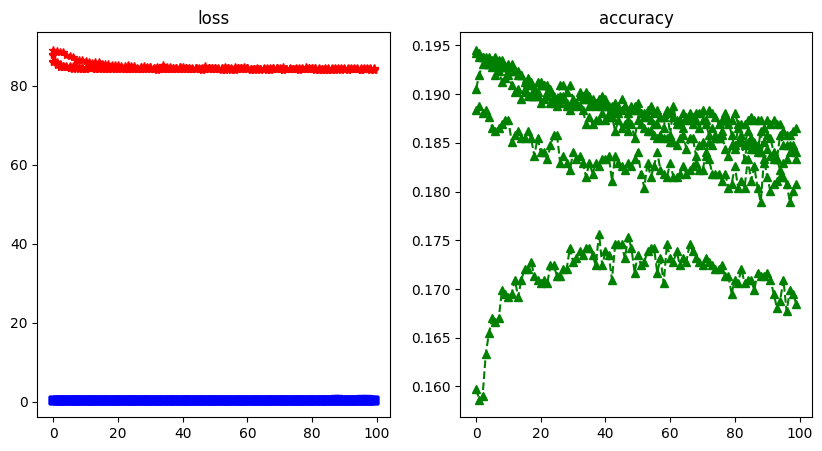

In [30]:
batch_size = 64
seq_length = 6
folds = 5
repeats = 12
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} for training")

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = pMHC_TCR_model(input_size=237, hidden_size=5, batch_size=batch_size, num_layers=2, device=device, use_whole_data=False).to(device)
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
weights = torch.FloatTensor([5,6])
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("loss")
ax[1].set_title("accuracy")

for fold, (train_idx, test_idx) in enumerate(kf.split(TCRData.X, TCRData.y)):
    print(f"-------------------Fold {fold}-------------------")
    if batch_size == 1:
    # using the subsampler to get the data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_dataset = torch.utils.data.Subset(TCRData, train_idx)
        test_dataset = torch.utils.data.Subset(TCRData, test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(train_dataset), sampler=train_subsampler)
        test_loader = torch.utils.data.DataLoader(TCRData, batch_size=len(test_dataset), sampler=test_subsampler)
    else:
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        train_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=train_subsampler, drop_last=True)
        test_loader = torch.utils.data.DataLoader(TCRData, 
            batch_size=batch_size, sampler=test_subsampler, drop_last=True)
        
    model.apply(reset_weights)
    train_losses_history = []
    test_losses_history = []
    accuracy_history = []

    for epoch in range(1, epochs+1):
        train_losses = train(fold, model, device, train_loader, optimizer, epoch)
        test_losses, correct = test(fold, model, device, test_loader)
        train_losses_history.append(train_losses)
        test_losses_history.append(test_losses)
        accuracy_history.append(correct)
    ax[0].plot(train_losses_history, "r*--" ,label=f"train loss fold{fold}")
    ax[0].plot(test_losses_history, "bs--", label=f"test loss fold{fold}")
    ax[1].plot(accuracy_history, "g^--", label=f"accuracy fold{fold}")

In [19]:
torch.nn.CrossEntropyLoss()

CrossEntropyLoss()

In [25]:
a = torch.randn((20, 1))
b = torch.randn((20, 1))
nn.CrossEntropyLoss()(a.view(1,20), b.view(1,20))

tensor(-11.8783)

# Some useful functions and class

In [ ]:
# put the sequence are similar, (the length of the sequence are different less than 5 aa) into a batch, and then use the autoencoder to encode the HLA sequence.

class LenMatchBatchSampler(data.BatchSampler):
    def __iter__(self):
        buckets = [[] for i in range(300)]
        yielded = 0

        for idx in self.sampler:
            count_zeros = int(torch.sum(self.sampler.data_source[idx] == 0) / 5)
            buckets[count_zeros].append(idx)

            if len(buckets[count_zeros]) == self.batch_size:
                batch = list(buckets[count_zeros])
                yield batch
                buckets[count_zeros] = []

        batch = []
        leftover = [idx for bucket in buckets for idx in bucket]

        for idx in leftover:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []

        if len(batch) > 0 and not self.drop_last:
            yield batch
            

In [12]:
# not use
# random_seq_len = [random.randint(i) for i in range(5)]
test_input = torch.empty(0)
for i in range(5):
    random_seq_len = random.randint(0, 300)
    input = torch.randint(5, 100, (1, random_seq_len))
    test_input = torch.cat((test_input, input), dim=0)

In [ ]:
# # not use
# # My may need to find a proper way to encode the HLA aa sequence, because there are 10 to 20 different HLA types and some of them have variants which are just one single aa difference.
# hla_list = list(set(df["HLA"]))
# hla_list.sort()
# hla_dict = dict()
# for i in range(len(hla_list)):
#     hla_dict[hla_list[i]] = i
# # The encoding could apply autoencoder to encode the HLA sequence.
# df["HLA_encode"] = df["HLA"].map(hla_dict)
# X_feature = np.hstack((X_feature, df["HLA_encode"].values.reshape(-1,1)))

In [11]:
# torch.randint(0, 10, (3, 5))
# torch.randperm(10)
random_seq_len = random.randint(0, 300)
input = torch.randint(0, 100, (1, 5*random_seq_len))
print(input.shape)

torch.Size([1, 415])
